In [ ]:
#Ce modèle est utilisé avec le modèle de fichier Model_Transfer_Learning_9classes. Si le modéle Model_Transfer_Learning_9classes
#trouve IG ou Neutrophil on execute le modèle  en bas pour trouver des sous-classes de IG ou Neutrophil.

In [2]:
import numpy as np
import pandas as pd
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Lambda, MaxPool2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import xml.etree.ElementTree as ET
import sklearn
import itertools
import scipy
import os
import csv
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from matplotlib import cm # To import new color cards
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.svm import SVC


In [36]:
filename1 = 'C:/Users/laleh/Documents/Pythons/projet_blood/tests_images/data_1_ALL.pkl'
df1= pickle.load(open(filename1, 'rb'))
filename2 = 'C:/Users/laleh/Documents/Pythons/projet_blood/tests_images/data_1_13_classes.pkl'
df2= pickle.load(open(filename2, 'rb'))

df1=df1[df1.label=='ALL']

df=pd.concat([df2, df1], ignore_index=True)
###  on peut écrire mieux cette partie!!
classes_others=['eosinophil',"platelet","erythroblast","monocyte","basophil","ALL",'lymphocyte']
df['out']=df.label
for i in range(len(df)):
    if df.loc[i,"label"] in classes_others:
        df.loc[i,"out"]=df.loc[i,"out"].replace(df.loc[i,"out"],"0")
        
    elif df.loc[i,"label"]=="BNE_BNE":  
        df.loc[i,"out"]=df.loc[i,"out"].replace(df.loc[i,"out"],"1")
    elif df.loc[i,"label"]=="BNE_SNE":
        df.loc[i,"out"]=df.loc[i,"out"].replace(df.loc[i,"out"],"2")
    elif df.loc[i,"label"]=="BNE_NEUTROPHIL":  
        df.loc[i,"out"]=df.loc[i,"out"].replace(df.loc[i,"out"],"3")
        
    elif df.loc[i,"label"]=="IG_MY":
        df.loc[i,"out"]=df.loc[i,"out"].replace(df.loc[i,"out"],"4")
    elif df.loc[i,"label"]=="IG_MMY":
        df.loc[i,"out"]=df.loc[i,"out"].replace(df.loc[i,"out"],"5")
    elif df.loc[i,"label"]=="IG_PMY":
        df.loc[i,"out"]=df.loc[i,"out"].replace(df.loc[i,"out"],"6")
    elif df.loc[i,"label"]=="IG_IG":
        df.loc[i,"out"]=df.loc[i,"out"].replace(df.loc[i,"out"],"7")
        


In [37]:
data_train, data_test = train_test_split(df, test_size=0.2, random_state=123)



In [40]:
print(len(list(data_train.out.unique())))
print(len(list(data_test.out.unique())))

8
8


In [41]:


train_data_generator=ImageDataGenerator(
preprocessing_function=preprocess_input,
rotation_range=10,
width_shift_range=0.1,
height_shift_range=0.1,
zoom_range=1.1,
horizontal_flip=True)

test_data_generator=ImageDataGenerator(preprocessing_function=preprocess_input)
batch_size = 32


train_generator = train_data_generator.flow_from_dataframe(dataframe=data_train,
                                                          directory="",
                                                           x_col = "path",
                                                           y_col='out',
                                                           class_mode ="sparse",
                                                          target_size = (224 , 224), 
                                                          batch_size = batch_size)

test_generator = test_data_generator.flow_from_dataframe(dataframe=data_test,
                                                          directory="",
                                                           x_col = "path",
                                                           y_col='out',
                                                           class_mode ="sparse",
                                                          target_size = (224 , 224), 
                                                          batch_size = batch_size)

Found 13777 validated image filenames belonging to 8 classes.
Found 3445 validated image filenames belonging to 8 classes.


In [42]:
from PIL import Image

def convert_image(X):
    X_img=[]
    for image in X:
        
        
             with Image.open(image) as im:

    
                    img = im.resize((224, 224))
                 
                    
                    a = np.asarray(img)
                    X_img.append(a) 
                    
                    
    return np.array(X_img)

# Load the images train
X_train_img= convert_image(data_train.path)
Y_train = data_train['out']

# Load the images test
X_test_img = convert_image(data_test.path)
Y_test = data_test['out']


# Modèle 

In [43]:

n_class=8



base_model=VGG16(weights='imagenet', include_top=False)
for layer in base_model.layers:
    layer.trainable=False
    
    
model=Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(n_class, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
history = model.fit_generator(generator=train_generator, 
                                epochs = 1,
                                steps_per_epoch = len(data_train)//batch_size,
                                validation_data=test_generator,
                                validation_steps=len(data_test)//batch_size
                                )
for layer in base_model.layers[-4:]:
    layer.trainable = True
    
    
model.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#model.summary()

history = model.fit_generator(generator=train_generator, 
                                epochs = 30,
                                steps_per_epoch = len(data_train)//batch_size,
                                validation_data=test_generator,
                                validation_steps=len(data_test)//batch_size
                                )


intermediate_layer_model = Model( inputs=model.input, outputs=model.layers[2].output)
X_train_features = intermediate_layer_model.predict(preprocess_input(X_train_img))
X_test_features = intermediate_layer_model.predict(preprocess_input(X_test_img))

svm = SVC(C=111)


grid = svm.fit(X_train_features,  data_train["out"])

C:\Users\laleh\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


430/430 [==============================] - 162s 346ms/step - loss: 1.2546 - acc: 0.6268 - val_loss: 1.2710 - val_acc: 0.6376


C:\Users\laleh\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/30
430/430 [==============================] - 153s 334ms/step - loss: 0.8044 - accuracy: 0.7136 - val_loss: 0.4332 - val_accuracy: 0.8294
Epoch 2/30
430/430 [==============================] - 144s 335ms/step - loss: 0.5914 - accuracy: 0.7709 - val_loss: 0.3726 - val_accuracy: 0.8420
Epoch 3/30
430/430 [==============================] - 144s 335ms/step - loss: 0.5298 - accuracy: 0.7964 - val_loss: 0.2874 - val_accuracy: 0.8870
Epoch 4/30
430/430 [==============================] - 143s 333ms/step - loss: 0.4877 - accuracy: 0.8127 - val_loss: 0.3009 - val_accuracy: 0.8770
Epoch 5/30
430/430 [==============================] - 143s 333ms/step - loss: 0.4616 - accuracy: 0.8184 - val_loss: 0.2781 - val_accuracy: 0.8887
Epoch 6/30
430/430 [==============================] - 144s 335ms/step - loss: 0.4542 - accuracy: 0.8204 - val_loss: 0.2738 - val_accuracy: 0.8949
Epoch 7/30
430/430 [==============================] - 144s 334ms/step - loss: 0.4325 - accuracy: 0.8293 - val_loss: 0.2508 -

In [45]:
classes_names=["Others","BNE_BNE","BNE_SNE","BNE_NEUTROPHIL","IG_MY","IG_MMY","IG_PMY","IG_IG"]
predictions_svm = svm.predict(X_test_features)

from sklearn.metrics import classification_report
print(classification_report(Y_test.values.astype(int),
predictions_svm.astype(int), target_names=classes_names))

                precision    recall  f1-score   support

        Others       0.99      0.99      0.99      2179
       BNE_BNE       0.82      0.80      0.81       313
       BNE_SNE       0.84      0.88      0.86       335
BNE_NEUTROPHIL       1.00      1.00      1.00         9
         IG_MY       0.78      0.75      0.77       262
        IG_MMY       0.75      0.75      0.75       205
        IG_PMY       0.77      0.79      0.78       113
         IG_IG       0.97      0.97      0.97        29

      accuracy                           0.92      3445
     macro avg       0.87      0.86      0.87      3445
  weighted avg       0.92      0.92      0.92      3445



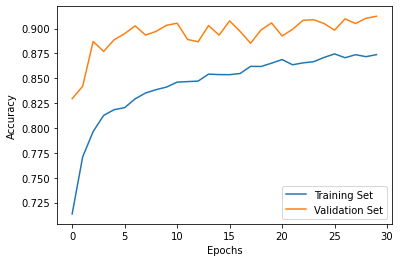

In [46]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

plt.figure()
plt.plot(np.arange(len(training_accuracy)), training_accuracy, label = 'Training Set')
plt.plot(np.arange(len(training_accuracy)), validation_accuracy, label = 'Validation Set')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

In [47]:
filename = 'svm_Transfer_Learning_B.pkl'
pickle.dump(svm, open(filename, 'wb'))

#svm= pickle.load(open(filename, 'rb'))

In [48]:
from tensorflow.keras.models import save_model, load_model
save_model(model,"model_Transfer_Learning_B")
#del model
#model=load_model("model_Transfer_Learning_B")

INFO:tensorflow:Assets written to: model_Transfer_Learning_B\assets
